In [5]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests

In [7]:
%%capture
%run -i -e main.ipynb

In [22]:
%%capture
%run -i -e Cluster_deepdive.ipynb

In [23]:
# Print or use the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair)

Top 10 pairs with highest correlation and cointegration:
('CRL', 'GNRC', 0.9878264114390971, 0.9999778048904727)
('TECH', 'ZBRA', 0.9852021364266428, 0.9998010198723981)
('AMAT', 'NXPI', 0.9837401770225843, 0.9992596723037133)
('CMG', 'NOW', 0.9836284339386753, 0.9983673890160912)
('EPAM', 'ISRG', 0.9791998981894826, 0.9981877444994156)
('GOOG', 'TECH', 0.9831065536573295, 0.9938096676361151)
('QRVO', 'SWKS', 0.9804828127252692, 0.9962628037510619)
('ADI', 'ZBRA', 0.9793659170073328, 0.9972210001417019)
('MCHP', 'NXPI', 0.9781278255519432, 0.9978203128778931)
('GOOGL', 'TECH', 0.9824335949479037, 0.9915945179156567)


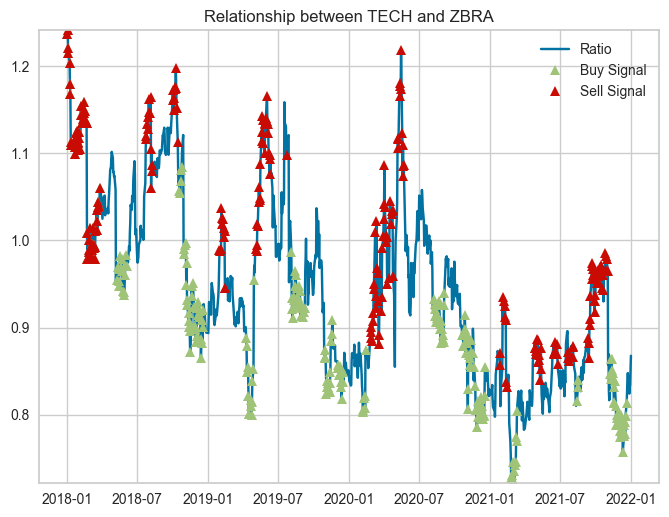

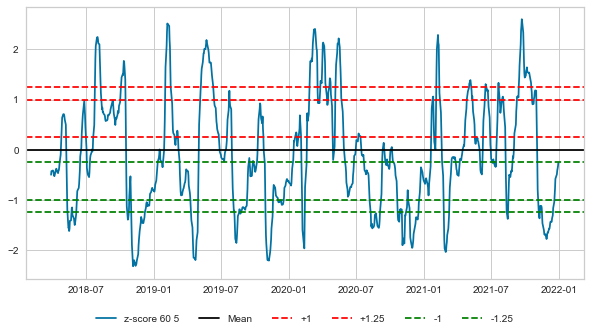

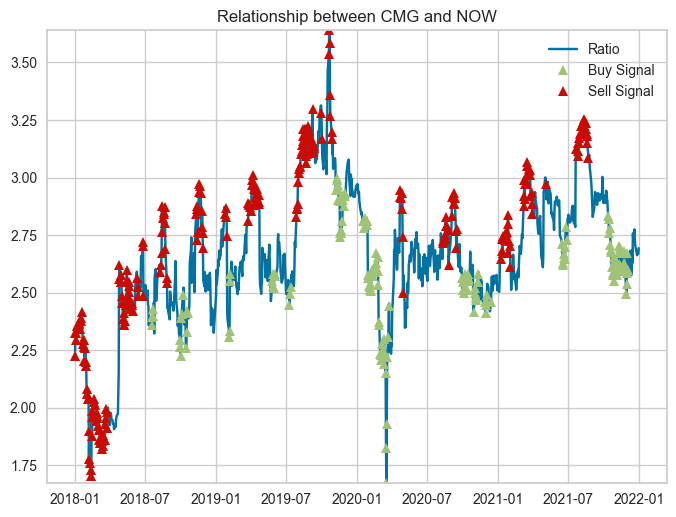

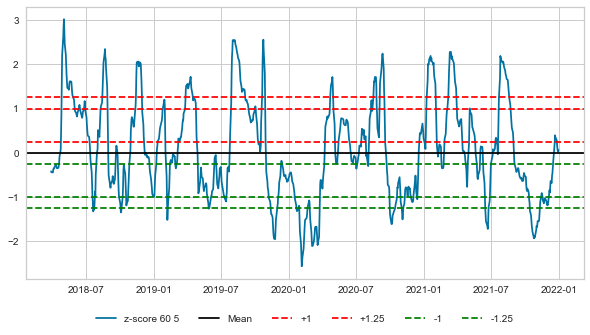

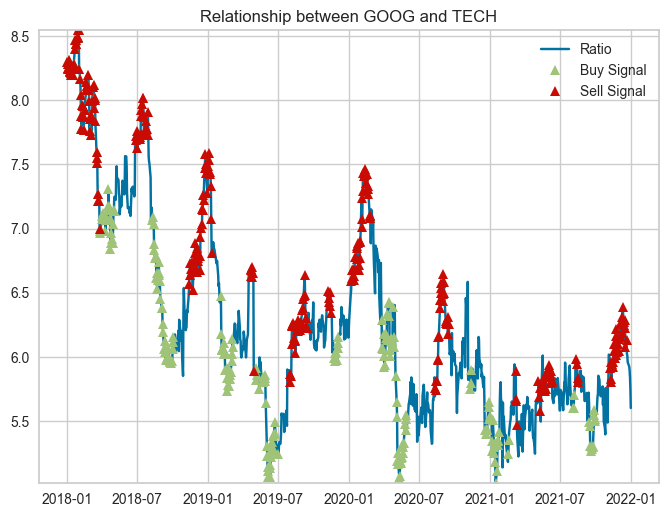

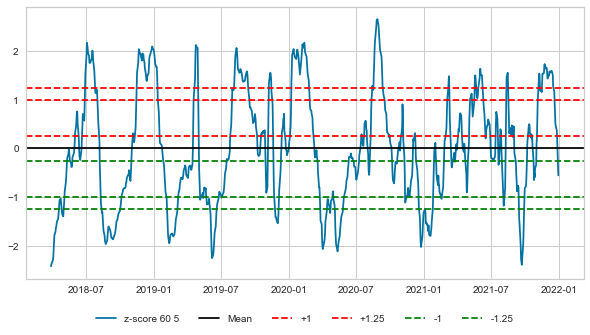

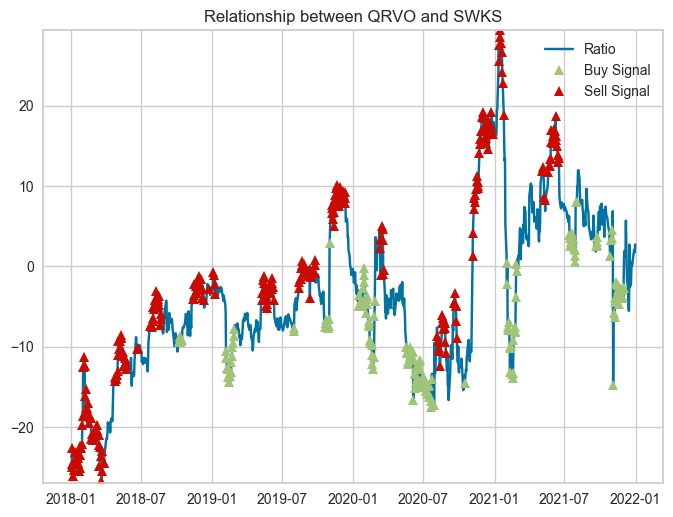

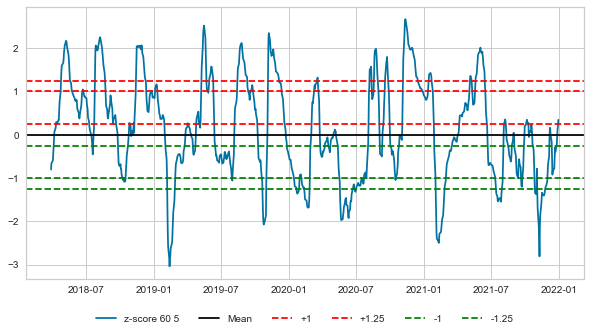

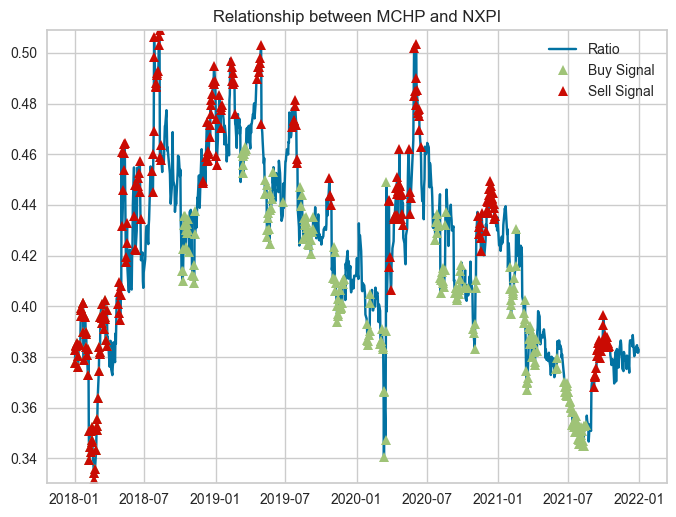

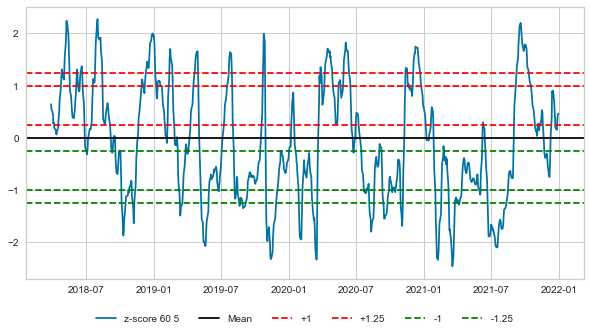

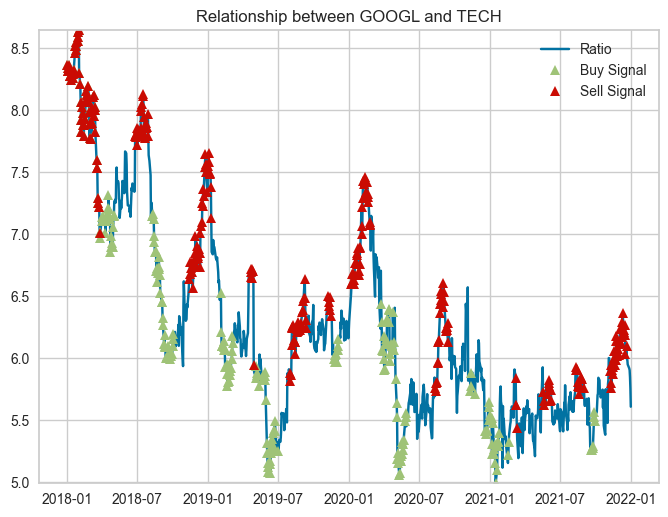

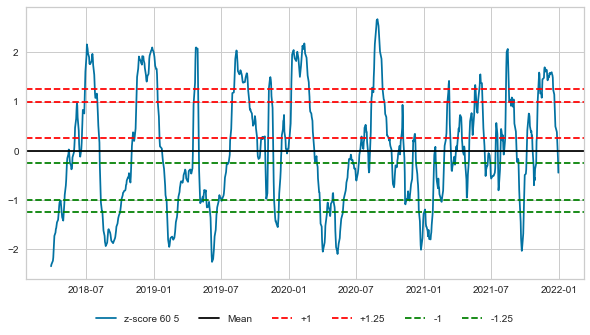

In [33]:
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = preferred_cluster[pair[0]]
    stock_2 = preferred_cluster[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

            plt.figure(figsize=(8, 6), dpi=100)
            plt.plot(ratio)
            buy = ratio.copy()
            sell = ratio.copy()
            buy[zscore_60_5>-1] = np.nan
            sell[zscore_60_5<1] = np.nan

            plt.plot(buy, color='g', linestyle='None', marker='^')
            plt.plot(sell, color='r', linestyle='None', marker='^')

            x1, x2, y1, y2 = plt.axis()
            plt.axis((x1, x2, ratio.min(), ratio.max()))
            plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
            plt.title(f'Relationship between {pair[0]} and {pair[1]}')
            plt.show()


            plt.figure(figsize=(10, 5))
            plt.plot(zscore_60_5)
            plt.axhline(0, color='black')
            plt.axhline(1, color='red', linestyle='--')
            plt.axhline(1.25, color='red', linestyle='--')
            plt.axhline(-1, color='green', linestyle='--')
            plt.axhline(-1.25, color='green', linestyle='--')
            plt.axhline(0.25, color='red', linestyle='--')
            plt.axhline(-0.25, color='green', linestyle='--')
            plt.legend(['z-score 60 5', 'Mean', '+1','+1.25','-1','-1.25'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
            plt.show()

In [94]:
# Trading strategy
total_profit = 0
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = preferred_cluster[pair[0]]
    stock_2 = preferred_cluster[pair[1]]
    result = ts.coint(stock_1, stock_2)
    p_val = result[1]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60


        # only trade pairs with p-value < 0.05
        trade_volume = 1000
        first_trade_day = 0 
        quant_1, quant_2 = 0, 0
        not_invested_1, not_invested_2 = 0, 0
        trade_sum = 0
        profit = 0
        # buy signals
        for day, zscore_value in enumerate(zscore_60_5):    
            if zscore_value < -1 and first_trade_day == 0: # long stock_1 and short stock_2 + get first trading day
                quant_1 += (trade_volume/2) // stock_1.iloc[day]
                quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                first_trade_day = day
                #print(first_trade_day)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value < -1: # long stock_1 and short stock_2
                quant_1 += (trade_volume/2) // stock_1.iloc[day]
                quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value > -0.25: # close trades
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]

                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                # reset values for building up next trade
                quant_1 = 0
                quant_2 = 0
                not_invested_1 = 0
                not_invested_2 = 0
                first_trade_day = 0
                trade_sum = 0
         
            if zscore_value < -3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]

                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                top_10_pairs.remove(pair)
                break

            expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
            if day == expiration_day and zscore_value < -1 : # close trades because it will take more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]

                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                top_10_pairs.remove(pair)
                break

        # reset values for sell signals
        first_trade_day = 0 
        quant_1, quant_2 = 0, 0
        not_invested_1, not_invested_2 = 0, 0
        trade_sum = 0
        # sell signals
        for day, zscore_value in enumerate(zscore_60_5):    
            if zscore_value > 1 and first_trade_day == 0: # short stock_1 and long stock_2 + get first trading day
                quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                quant_2 += (trade_volume/2) // stock_2.iloc[day]
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                first_trade_day = day
                #print(first_trade_day)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value > 1: # short stock_1 and long stock_2
                quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                quant_2 += (trade_volume/2) // stock_2.iloc[day]
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value < 0.25: # close trades
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]

                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                # reset values for building up next trade
                quant_1 = 0
                quant_2 = 0
                not_invested_1 = 0
                not_invested_2 = 0
                first_trade_day = 0
                trade_sum = 0
         
            if zscore_value > 3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]

                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                top_10_pairs.remove(pair)
                break

            expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
            if day == expiration_day and zscore_value > 1 : # close trades, since it took more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]

                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                top_10_pairs.remove(pair)
                break

    total_profit += profit
    total_profit = total_profit * 0.73625 # 26.375% capital gains tax & solidarity surcharge

    print("Stock 1:", pair[0], "| Stock 2:", pair[1], "| Profit in Dollar before taxes:", profit)
print("Total profit in Dollar after taxes:", total_profit)
    

Stock 1: CRL | Stock 2: GNRC | Profit in Dollar before taxes: 83249.05955123901
Stock 1: TECH | Stock 2: ZBRA | Profit in Dollar before taxes: 131302.28105163574
Stock 1: AMAT | Stock 2: NXPI | Profit in Dollar before taxes: 62541.01678848266
Stock 1: EPAM | Stock 2: ISRG | Profit in Dollar before taxes: 113067.19830322266
Stock 1: GOOG | Stock 2: TECH | Profit in Dollar before taxes: 666988.7756347656
Stock 1: ADI | Stock 2: ZBRA | Profit in Dollar before taxes: 87812.36210632324
Stock 1: MCHP | Stock 2: NXPI | Profit in Dollar before taxes: 62631.469049453735
Stock 1: GOOGL | Stock 2: TECH | Profit in Dollar before taxes: 643623.8985290527
Total profit in Dollar after taxes: 795854.1539672172


In [97]:
stock_1.iloc[120]

1139.280029296875